In [3]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from src import project_dir

In [4]:

def plot_feature_selection_tradeoff(results_dir):
    """
    Plot cost vs. accuracy for feature selection experiments.

    Expects 'results.csv' with columns: ['method', 'accuracy', 'cost']
    - 'no_gates_tuned' will be shown in red.
    - 'gates' methods will be shown in other colors.
    """
    results_path = os.path.join(results_dir, 'results.csv')
    if not os.path.isfile(results_path):
        raise FileNotFoundError(f"Could not find 'results.csv' in {results_dir}")

    df = pd.read_csv(results_path)

    if not {'method', 'accuracy', 'cost'}.issubset(df.columns):
        raise ValueError("CSV must contain 'method', 'accuracy', and 'cost' columns.")

    plt.figure(figsize=(8, 6))

    # Plot gate-tuned models
    df_gates = df[df['method'].str.contains('gates', case=False)]
    plt.scatter(df_gates['cost'], df_gates['accuracy'], label='With Gates', c='blue', alpha=0.7)

    # Plot baseline (no gates)
    df_baseline = df[df['method'] == 'no_gates_tuned']
    plt.scatter(df_baseline['cost'], df_baseline['accuracy'], label='No Gates (tuned)', c='red', s=100, edgecolors='black')

    # Labels and legend
    plt.xlabel('Cost')
    plt.ylabel('Accuracy')
    plt.title('Feature Selection: Accuracy vs. Cost')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

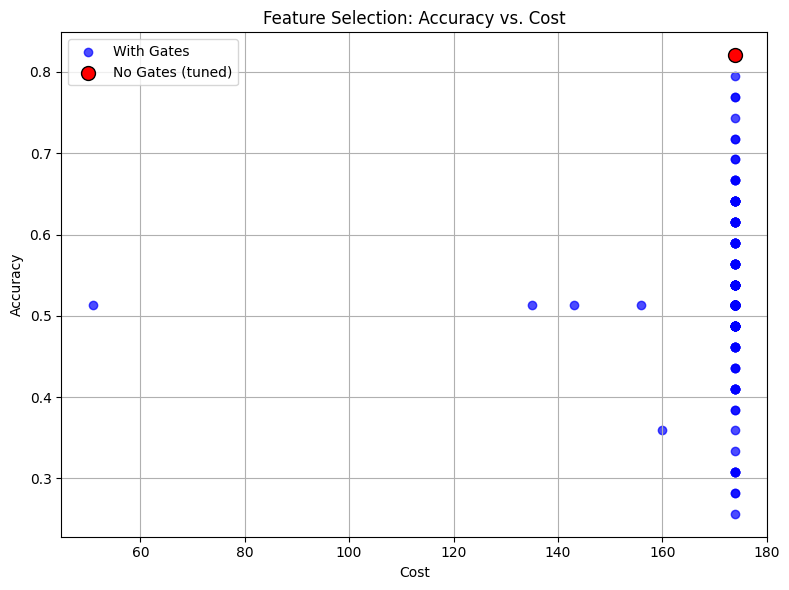

In [5]:
results_dir = os.path.join(project_dir, 'logs', 'concrete_test___2025.07.29-12.31.39.999')
plot_feature_selection_tradeoff(results_dir)

### HAR dataset

In [27]:
import os
from src import project_dir
import pandas as pd
import numpy as np

dataset_dir = os.path.join(project_dir, 'data', 'HAR', 'UCI HAR Dataset')

columns=['acc_x', 'acc_y', 'acc_z', 'gyro_x', 'gyro_y', 'gyro_z', 'subject', 'label']


In [28]:
def extract_har_data(phase='train'):
    assert phase in ['train', 'test'], "Phase must be either 'train' or 'test'."

    phase_dir = os.path.join(dataset_dir, phase)
    files = [f'body_acc_x_{phase}.txt', f'body_acc_y_{phase}.txt', f'body_acc_z_{phase}.txt',
             f'body_gyro_x_{phase}.txt', f'body_gyro_y_{phase}.txt', f'body_gyro_z_{phase}.txt']
    df = pd.DataFrame()

    subjects = np.loadtxt(os.path.join(phase_dir, f'subject_{phase}.txt'), dtype=int)
    labels = np.loadtxt(os.path.join(phase_dir, f'y_{phase}.txt'), dtype=int)

    for file_idx, file in enumerate(files):
        x_file_path = os.path.join(phase_dir, 'Inertial Signals', file)
        if not os.path.exists(x_file_path):
            raise FileNotFoundError(f"File {x_file_path} does not exist.")
        
        data = np.loadtxt(x_file_path)
        column_name = columns[file_idx]

        for i in range(data.shape[0]):
            subject_id = subjects[i]
            label = labels[i]
            if i == 0:
                signal = data[i, :]
                subject_id_array = np.repeat(subject_id, signal.shape[0])
                label_array = np.repeat(label, signal.shape[0])
            else:
                # there is a window overlap of 50%, so we take the second half of every signal except the first
                # merge this with the previous signal
                signal = np.concatenate((signal, data[i, data.shape[1] // 2:]), axis=0)
                subject_id_array = np.concatenate((subject_id_array, np.repeat(subject_id, data.shape[1] // 2)), axis=0)
                label_array = np.concatenate((label_array, np.repeat(label, data.shape[1] // 2)), axis=0)


        # copy the signal to the corresponding column vertically
        df[column_name] = signal

        if file_idx == 0:
            df['subject'] = subject_id_array
            df['label'] = label_array

    # re-organize dataframe columns
    df = df[columns]
    return df

In [30]:
train_df = extract_har_data(phase='train')
test_df = extract_har_data(phase='test')

# concatenate vertically both dataframes
df = pd.concat([train_df, test_df], axis=0, ignore_index=True)
df.to_csv(os.path.join(project_dir, 'data', 'HAR.csv'), index=False)

### WISDM dataset

In [ ]:
import os
import pandas as pd
import numpy
import re
from src import project_dir

dataset_dir = os.path.join(project_dir, 'data', 'wisdm', 'wisdm-dataset')

individuals = list(range(1600, 1651))  # 1600 to 1650 inclusive
devices = ['phone', 'watch']
sensors = ['accel', 'gyro']


alldf = pd.DataFrame()

for indiv in individuals:
    indiv_df = pd.DataFrame()

    i = 0
    for device in devices:
        for sensor in sensors:
            datadir = os.path.join(dataset_dir, 'raw', device, sensor)
            datafile = os.path.join(datadir, f'data_{indiv}_{sensor}_{device}.txt')
            if not os.path.isfile(datafile):
                raise FileNotFoundError(f"Data file {datafile} does not exist.")

            df = pd.read_csv(datafile, header=None, names=['subject', 'activity', 'timestamp', 'x', 'y', 'z'])
            df[df.columns[-1]] = df[df.columns[-1]].str.rstrip(';') 
            # print(f"Processing indiv {indiv} device {device} sensor {sensor}...")
            # print(f"Data shape: {df.shape}")

            indiv_df[f'{device}_{sensor}_x'] = df['x']
            indiv_df[f'{device}_{sensor}_y'] = df['y']
            indiv_df[f'{device}_{sensor}_z'] = df['z']
            if i == 0:
                indiv_df['subject'] = df['subject']
                indiv_df['label'] = df['activity'].apply(lambda x: ord(x.upper()) - ord('A'))
            i += 1

    # remove NaN rows from indiv_df
    indiv_df = indiv_df.dropna()
    alldf = pd.concat([alldf, indiv_df], axis=0, ignore_index=True)


columns = [col for col in alldf.columns if col not in ['subject', 'label']] + ['subject', 'label']
alldf = alldf[columns]
alldf.to_csv(os.path.join(project_dir, 'data', 'wisdm.csv'), index=False)


Processing indiv 1600 device phone sensor accel...
Data shape: (64311, 6)
Processing indiv 1600 device phone sensor gyro...
Data shape: (64247, 6)
Processing indiv 1600 device watch sensor accel...
Data shape: (65462, 6)
Processing indiv 1600 device watch sensor gyro...
Data shape: (65435, 6)
Processing indiv 1601 device phone sensor accel...
Data shape: (81457, 6)
Processing indiv 1601 device phone sensor gyro...
Data shape: (81193, 6)
Processing indiv 1601 device watch sensor accel...
Data shape: (64840, 6)
Processing indiv 1601 device watch sensor gyro...
Data shape: (64829, 6)
Processing indiv 1602 device phone sensor accel...
Data shape: (84890, 6)
Processing indiv 1602 device phone sensor gyro...
Data shape: (64286, 6)
Processing indiv 1602 device watch sensor accel...
Data shape: (64985, 6)
Processing indiv 1602 device watch sensor gyro...
Data shape: (64950, 6)
Processing indiv 1603 device phone sensor accel...
Data shape: (81841, 6)
Processing indiv 1603 device phone sensor gy

### HARTH dataset